<a href="https://colab.research.google.com/github/LaZoark/anomaly_detection/blob/main/%5BBD%5D%5BSingle_dev%5DHW3_aircraft_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

True Positive Rate (TPR) is a synonym for **Sensitivity**(recall) and is therefore defined as follows:  **TPR=TP/(TP+FN)**
<!-- $$TPR = \frac{TP} {TP + FN}$$ -->
False Positive Rate (FPR) is defined as follows:  **FPR=FP/(FP+TN)**
<!-- $$FPR = \frac{FP} {FP + TN}$$ -->

Should take a look of [this](https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077).

## Setup

In [ ]:
!pip install wandb omegaconf hydra -qqq
# import wandb
# wandb.login()
from omegaconf import DictConfig, OmegaConf
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
# from wandb.keras import WandbCallback
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from keras.layers import LSTM, TimeDistributed, RepeatVector, Layer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay
from scipy.signal import savgol_filter
# import logging
# log = logging.getLogger(__name__)

     |████████████████████████████████| 1.8 MB 18.3 MB/s 
     |████████████████████████████████| 78 kB 3.1 MB/s 
     |████████████████████████████████| 82 kB 661 kB/s 
     |████████████████████████████████| 181 kB 71.0 MB/s 
     |████████████████████████████████| 145 kB 56.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 117 kB 54.1 MB/s 
     |████████████████████████████████| 596 kB 58.2 MB/s 


In [ ]:
# DATA_SET = 'a'
# DATA_SET = 'b'
DATA_SET = 'c'
# DATA_SET = 'd'
# DATA_SET = 'e'

if DATA_SET == 'e':
  conf = {
      "lr": 0.005,
      "epoch": 100,
      "batch_size": 128,
      "loss_func": "mse",
      "dropout": 0.2,
      "architecture": "AE",
      # "architecture": "lstm_AE",
      "dataset": "sensor_E",
      "TIME_STEPS": 16,
      # "TIME_STEPS": 64,
      "kernel_size": 8,
      # "param_m": 1,
      "param_m": 2,
      "stride": 2,
      # "polyorder": 2,
      # "scaler": 'savgol_filter',
      "scaler": 'MinMax',
      # "scaler": 'Robust',
      # "scaler": 'Standard',
      # "scaler": 'None',
  }
elif DATA_SET == 'b':
  conf = {
      "lr": 0.006,
      # "lr": 0.0008,
      "epoch": 100,
      "batch_size": 32,
      "loss_func": "mse",
      "dropout": 0.18,
      "architecture": "AE",
      # "architecture": "lstm_AE",
      "dataset": "sensor_B",
      "TIME_STEPS": 128,
      # "TIME_STEPS": 88,
      "kernel_size": 8,
      "param_m": 1,
      "stride": 1,
      # "polyorder": 2,
      # "scaler": 'savgol_filter',
      # "scaler": 'MinMax',
      "scaler": 'Robust',
      # "scaler": 'Standard',
      # "scaler": 'None',
  }
elif DATA_SET == 'c':
  conf = {
      "lr": 0.005,
      "epoch": 100,
      "batch_size": 64,
      "loss_func": "mse",
      "dropout": 0.2,
      "architecture": "AE",
      # "architecture": "lstm_AE",
      "dataset": "sensor_C",
      "TIME_STEPS": 32,
      # "TIME_STEPS": 16,
      "kernel_size": 8,
      # "param_m": 1,
      "param_m": 2,
      "stride": 2,
      # "polyorder": 4,
      # "scaler": 'savgol_filter',
      # "scaler": 'MinMax',
      "scaler": 'Robust',
      # "scaler": 'Standard',
      # "scaler": 'None',
  }

elif DATA_SET == 'a':
  conf = {
      # "lr": 0.012,
      "lr": 0.0077,
      "epoch": 100,
      # "batch_size": 160,
      "batch_size": 256,
      "loss_func": "mse",
      "dropout": 0.2,
      "architecture": "AE",
      # "architecture": "lstm_AE",
      "dataset": "sensor_A",
      "TIME_STEPS": 120,
      # "TIME_STEPS": 96,
      "kernel_size": 8,
      "param_m": 2,
      # "param_m": 1,
      "stride": 2,
      # "polyorder": 2,
      # "scaler": 'savgol_filter',
      # "scaler": 'MinMax',
      # "scaler": 'Robust',
      "scaler": 'Standard',
      # "scaler": 'None',
  }
elif DATA_SET == 'd':
  conf = {
      "lr": 0.01,
      "epoch": 100,
      "batch_size": 32,
      "loss_func": "mse",
      "dropout": 0.2,
      "architecture": "AE",
      # "architecture": "lstm_AE",
      "dataset": "sensor_D",
      "TIME_STEPS": 64,
      "kernel_size": 8,
      "param_m": 1,
      "stride": 2,
      "polyorder": 2,
      "scaler": 'savgol_filter',
      # "scaler": 'MinMax',
      # "scaler": 'Robust',
      # "scaler": 'Standard',
      # "scaler": 'None',
      # "tag": 'layer modified',
  }

# wandb.init(project="BD_hw3", 
#            entity="lazoark",
#            config=conf,
#           #  notes='formal',
#            tags='formal',
#           )
# config = wandb.config
config = conf

In [ ]:
# wandb.finish()

In [ ]:
# wandb.config["TIME_STEPS"] = 120
# wandb.config["batch_size"] = 64
# config = wandb.config

## Load and Visualize the data

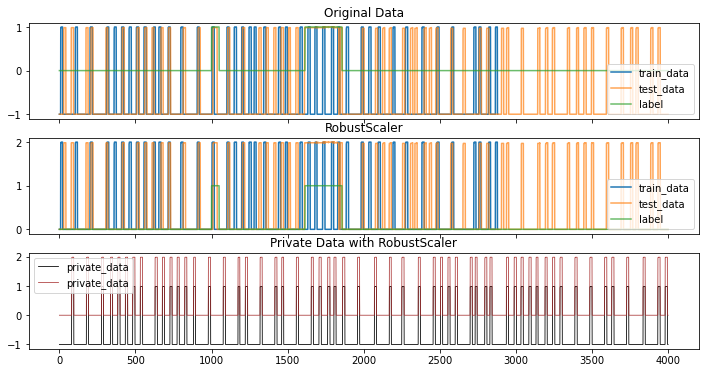

In [ ]:
#@title Preprocessing and Visualizing {display-mode: "form"}
train_data = pd.read_csv(
    f'{config["dataset"]}_normal.csv', parse_dates=True)
test_data = pd.read_csv(
    f'{config["dataset"]}_public.csv', parse_dates=True)
private_data = pd.read_csv(
    f'{config["dataset"]}_private.csv', parse_dates=True)
# Drop last column of a dataframe
# test_data = test_data.iloc[: , :-1]
# print(train_data.columns)
train_data.columns = ['train_data']
test_data.columns = ['test_data', 'label']
private_data.columns = ['private_data']
# print(train_data.head())
# print(test_data.head())

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12,6), sharex=True)
train_data.plot(legend=True, ax=ax0, title='Original Data')
test_data.plot(legend=True, ax=ax0, alpha=0.7)
private_data.plot(legend=True, ax=ax2, color='black', linewidth=0.8)

if config['scaler'] == 'Standard':
  train_data['train_data'] = StandardScaler().fit_transform(pd.DataFrame(train_data['train_data']))
  test_data['test_data'] = StandardScaler().fit_transform(pd.DataFrame(test_data['test_data']))
  private_data['private_data'] = StandardScaler().fit_transform(pd.DataFrame(private_data['private_data']))
  title = 'StandardScaler'
elif config['scaler'] == 'MinMax':
  train_data['train_data'] = MinMaxScaler().fit_transform(pd.DataFrame(train_data['train_data']))
  test_data['test_data'] = MinMaxScaler().fit_transform(pd.DataFrame(test_data['test_data']))
  private_data['private_data'] = MinMaxScaler().fit_transform(pd.DataFrame(private_data['private_data']))
  title = 'MinMaxScaler'
elif config['scaler'] == 'Robust':
  train_data['train_data'] = RobustScaler().fit_transform(pd.DataFrame(train_data['train_data']))
  test_data['test_data'] = RobustScaler().fit_transform(pd.DataFrame(test_data['test_data']))
  private_data['private_data'] = RobustScaler().fit_transform(pd.DataFrame(private_data['private_data']))
  title = 'RobustScaler'
elif config['scaler'] == 'MaxAbs':
  train_data['train_data'] = MaxAbsScaler().fit_transform(pd.DataFrame(train_data['train_data']))
  test_data['test_data'] = MaxAbsScaler().fit_transform(pd.DataFrame(test_data['test_data']))
  private_data['private_data'] = MaxAbsScaler().fit_transform(pd.DataFrame(private_data['private_data']))
  title = 'MaxAbsScaler'
elif config['scaler'] == 'savgol_filter':
  width = config['TIME_STEPS']
  # width = 8
  polyorder = config['polyorder']
  # polyorder = 3
  train_data['train_data'] = savgol_filter(train_data['train_data'], width+1 if width%2==0 else width, polyorder)
  test_data['test_data'] = savgol_filter(test_data['test_data'], width+1 if width%2==0 else width, polyorder)
  private_data['private_data'] = savgol_filter(private_data['private_data'], width+1 if width%2==0 else width, polyorder)
  title = 'savgol_filter'
else:
  title = 'None'


train_data.plot(legend=True, ax=ax1, title=title)
test_data.plot(legend=True, ax=ax1, alpha=0.7)
private_data.plot(legend=True, ax=ax2, title=f'Private Data with {title}', color='brown', linewidth=0.8, alpha=0.9)
# wandb.log({"Preprocessing": wandb.Image(fig)})
# plt.tight_layout()
plt.show()

## Prepare training data

In [ ]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = train_data.mean()
training_std = train_data.std()
df_training_value = pd.DataFrame((train_data - training_mean) / training_std)
print(f"Number of training samples: {len(df_training_value)}")

Number of training samples: 2880


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [ ]:
#@title looping sliding window {display-mode: "form"}
seq = [0, 1, 2, 3, 4, 5, 6]
window_size = 4

temp = 0
for i in range(len(seq)):
  if len(seq) - window_size >= i:
    # print(seq[i: i + window_size])
    pass
  elif len(seq) - window_size < i:
    temp_list = []
    temp += 1
    temp_list.append(seq[i : (i + window_size - temp)])
    temp_list.append(seq[:temp])
    temp_list = list(np.concatenate(temp_list))
    # print(seq[-temp: (i + window_size-temp)])
    # print(temp_list)

In [ ]:
#@title create_sequences {display-mode: "form"}
TIME_STEPS = config["TIME_STEPS"]
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, loop=0):
  output = []
  if not loop:
    for i in range(len(values) - time_steps + 1):
      output.append(values[i : (i + time_steps)])
  elif loop:
    temp = 0
    for i in range(len(values)):
      if len(values) - time_steps >= i:
        output.append(values[i : (i + time_steps)])
      elif len(values) - time_steps < i:
        temp += 1
        temp_list = []
        temp_list.append(values[i : (i + time_steps - temp)])
        temp_list.append(values[:temp])
        temp_list = list(np.concatenate(temp_list))
        output.append(temp_list)
  return np.stack(output)

x_train = create_sequences(df_training_value.values)
print(f"Training input shape: {x_train.shape}")

Training input shape: (2849, 32, 1)


## Build a model

convolutional reconstruction autoencoder model  
The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape.

In [ ]:
# model = keras.Sequential([
#         layers.Input(shape=(x_train.shape[1], x_train.shape[2])), # size of the TIME_STEP
#         layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Dropout(rate=config["dropout"]),
#         layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Dropout(rate=config["dropout"]),
#         layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
#     ])
k_size = config['kernel_size']
stride = config['stride']
s = config['param_m']

if config["architecture"] == "lstm_AE":
  timesteps, n_features = x_train.shape[1], x_train.shape[2]
  lstm_autoencoder = keras.Sequential()
  # Encoder
  lstm_autoencoder.add(LSTM(s*32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
  lstm_autoencoder.add(layers.Dropout(rate=config["dropout"]))
  lstm_autoencoder.add(LSTM(s*16, activation='relu', return_sequences=False))
  lstm_autoencoder.add(layers.Dropout(rate=config["dropout"]))
  # lstm_autoencoder.add(LSTM(s*8, activation='relu', return_sequences=False))
  lstm_autoencoder.add(RepeatVector(timesteps))
  # Decoder
  # lstm_autoencoder.add(LSTM(s*8, activation='relu', return_sequences=True))
  lstm_autoencoder.add(LSTM(s*16, activation='relu', return_sequences=True))
  lstm_autoencoder.add(layers.Dropout(rate=config["dropout"]))
  lstm_autoencoder.add(LSTM(s*32, activation='relu', return_sequences=True))
  lstm_autoencoder.add(TimeDistributed(layers.Dense(n_features)))
  model = lstm_autoencoder

elif config["architecture"] == "AE":
  # model = keras.Sequential([
  #   layers.Input(shape=(x_train.shape[1], x_train.shape[2])), # size of the TIME_STEP
  #   layers.Conv1D(filters=s*32, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
  #   layers.Dropout(rate=config["dropout"]),
  #   layers.Conv1D(filters=s*16, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
  #   layers.Conv1D(filters=s*4, kernel_size=k_size, padding="same", strides=stride, activation="relu"),

  #   layers.Conv1DTranspose(filters=s*4, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
  #   layers.Conv1DTranspose(filters=s*16, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
  #   layers.Dropout(rate=config["dropout"]),
  #   layers.Conv1DTranspose(filters=s*32, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
  #   layers.Conv1DTranspose(filters=1, kernel_size=k_size, padding="same"),
  # ])
    model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1], x_train.shape[2])), # size of the TIME_STEP
    layers.Conv1D(filters=s*64, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
    layers.Dropout(rate=config["dropout"]),
    layers.Conv1D(filters=s*32, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
    layers.Conv1D(filters=s*4, kernel_size=k_size, padding="same", strides=stride, activation="relu"),

    layers.Conv1DTranspose(filters=s*4, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
    layers.Conv1DTranspose(filters=s*32, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
    layers.Dropout(rate=config["dropout"]),
    layers.Conv1DTranspose(filters=s*64, kernel_size=k_size, padding="same", strides=stride, activation="relu"),
    layers.Conv1DTranspose(filters=1, kernel_size=k_size, padding="same"),
  ])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=config["lr"]), loss=config["loss_func"])
model.summary()

Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_394 (Conv1D)         (None, 16, 128)           1152      
                                                                 
 dropout_267 (Dropout)       (None, 16, 128)           0         
                                                                 
 conv1d_395 (Conv1D)         (None, 8, 64)             65600     
                                                                 
 conv1d_396 (Conv1D)         (None, 4, 8)              4104      
                                                                 
 conv1d_transpose_526 (Conv1  (None, 8, 8)             520       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_527 (Conv1  (None, 16, 64)           4160      
 DTranspose)                                        

## Train the model

using `x_train` as both the input and the target
since this is a reconstruction model.

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=config["epoch"],
    batch_size=config["batch_size"],
    validation_split=0.1,
    # shuffle=True,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
        # Use the WandbCallback to automatically save all the metrics tracked in model.fit() to your dashboard
        # WandbCallback(),
    ],
)

Epoch 1/100
41/41 [==============================] - 2s 14ms/step - loss: 0.4094 - val_loss: 0.1040
Epoch 2/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0774 - val_loss: 0.0569
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0524 - val_loss: 0.0355
Epoch 4/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0382 - val_loss: 0.0476
Epoch 5/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0353 - val_loss: 0.0231
Epoch 6/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0266 - val_loss: 0.0205
Epoch 7/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0218 - val_loss: 0.0219
Epoch 8/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0205 - val_loss: 0.0098
Epoch 9/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0176 - val_loss: 0.0144
Epoch 10/100
41/41 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0026
Epoch 11

plot training and validation loss to see how the training went

In [ ]:
# plt.plot(history.history["loss"], label="Training Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
# plt.legend()
# plt.show()

## Detecting anomalies on training data to get the `threshold`


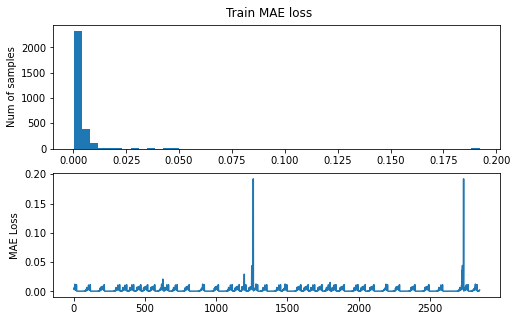

Reconstruction error threshold: 0.1920763012359807


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
# train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
train_mae_loss = np.mean(np.square(x_train_pred - x_train), axis=1)

fig, axs = plt.subplots(2, 1, figsize=(8, 5))
fig.suptitle('Train MAE loss', y=0.93)
axs[0].hist(train_mae_loss, bins=50)
axs[0].set(ylabel="Num of samples")
axs[1].plot(train_mae_loss)
axs[1].set(ylabel="MAE Loss")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print(f"Reconstruction error threshold: {threshold}")

### Compare recontruction

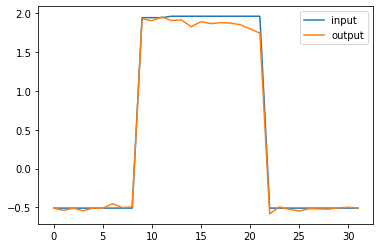

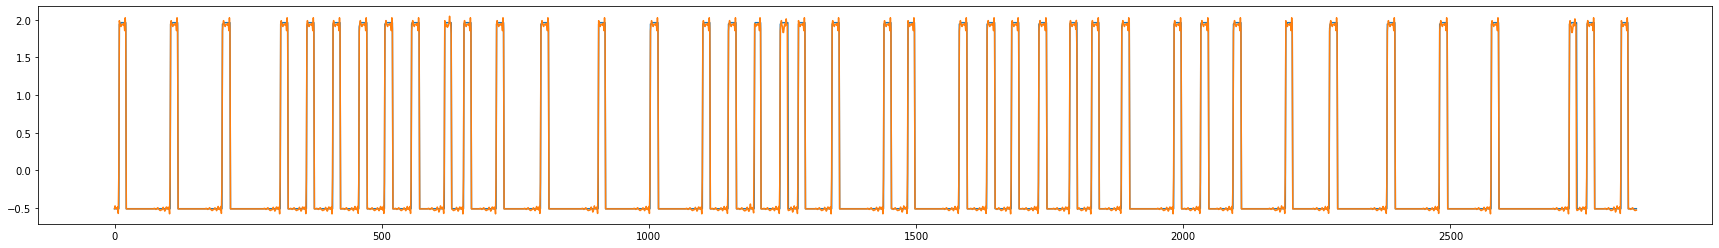

In [ ]:
# Checking how the first sequence is learnt
fig, ax = plt.subplots()
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.legend(['input', 'output'])
# wandb.log({"train_recontruction": wandb.Image(fig)})
plt.show()

fig, ax = plt.subplots(figsize=(30, 4))
plt.plot(x_train[:, 0, -1])
plt.plot(x_train_pred[:, 0, -1])
plt.show()

### Prepare test and private data

In [ ]:
df_test_value = pd.DataFrame((test_data['test_data'] - training_mean.values) / training_std.values)  # avoid from the information leaking
x_test = create_sequences(df_test_value.values)
print(f"Test input shape: {x_test.shape}")
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.square(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
test_mae_loss = np.resize(test_mae_loss, len(test_mae_loss) + config['TIME_STEPS'] - 1)
# Get private MAE loss.
df_private_value = pd.DataFrame((private_data['private_data'] - training_mean.values) / training_std.values)
x_private = create_sequences(df_private_value.values)
x_private_pred = model.predict(x_private)
private_mae_loss = np.mean(np.square(x_private_pred - x_private), axis=1)
private_mae_loss = private_mae_loss.reshape((-1))
private_mae_loss = np.resize(private_mae_loss, len(private_mae_loss) + config['TIME_STEPS'] - 1)

# Calculate TPR & FPR under all decision thresholds
fpr, tpr, thresholds = roc_curve(np.array(test_data['label']), test_mae_loss)
roc_auc = roc_auc_score(np.array(test_data['label']), test_mae_loss)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
threshold = thresholds[ix]
# threshold = np.max(train_mae_loss)

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
anomalies_private = private_mae_loss > threshold
tempg = np.where(anomalies)[0]
tempg_private = np.where(anomalies_private)[0]
print(f'Best Threshold = {threshold}')#', G-Mean = {gmeans[ix].round(3)}')
print(f"[public ]Number of anomaly samples: {np.sum(anomalies)}")
print(f"[private]Number of anomaly samples: {np.sum(anomalies_private)}")
print(f"Reconstruction error threshold: {threshold}")
# print(f"Indices of anomaly samples: {np.where(anomalies)}")

predict_data = [0]*4000
for j in tempg: predict_data[j] = 1

TN, FP, FN, TP = confusion_matrix(np.array(test_data['label']), predict_data).ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FN + FP + TN)
f1_score = 2*TP / (2*TP + FP + FN)

Test input shape: (3969, 32, 1)
Best Threshold = 0.04097284044175638
[public ]Number of anomaly samples: 286
[private]Number of anomaly samples: 4
Reconstruction error threshold: 0.04097284044175638


# Metrics

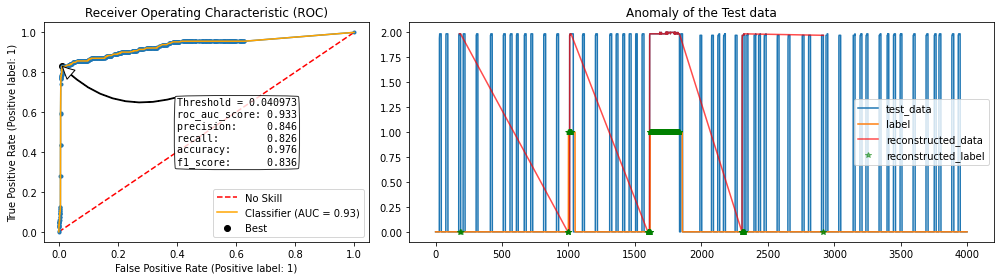

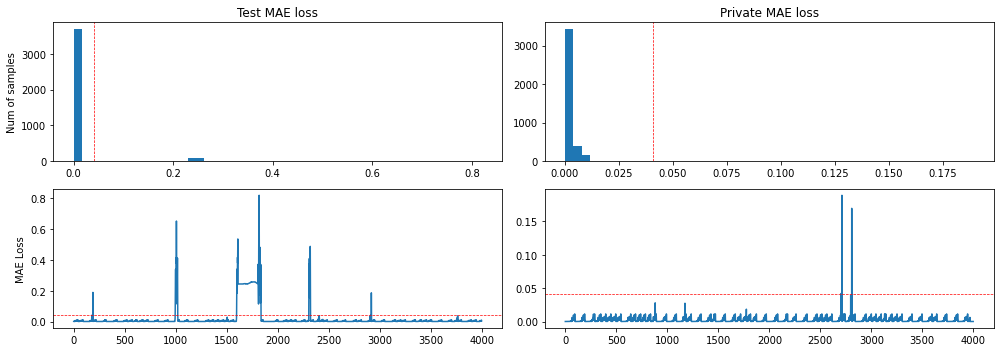

In [ ]:
fig_auc, axs = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={'width_ratios': [5, 9]})
axs[0].set_title('Receiver Operating Characteristic (ROC)')
axs[0].plot([0, 1], [0, 1], 'r--', label='No Skill')
axs[0].plot(fpr, tpr, marker='.')
axs[0].scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
RocCurveDisplay.from_predictions(np.array(test_data['label']), test_mae_loss, ax=axs[0], color='orange')
axs[0].annotate('Threshold = ' + str(threshold.round(6)) +
                '\n' + 'roc_auc_score:'.ljust(15) + str(roc_auc.round(3)) +
                '\n' + 'precision:'.ljust(15)     + str(precision.round(3)) +
                '\n' + 'recall:'.ljust(15)        + str(recall.round(3)) +
                '\n' + 'accuracy:'.ljust(15)      + str(accuracy.round(3)) +
                '\n' + 'f1_score:'.ljust(15)      + str(f1_score.round(3)),
             xy=([fpr[ix], tpr[ix]]), xytext=(0.4, 0.5),
             size=10, fontfamily='monospace', va="center", ha="left",
             bbox=dict(boxstyle="round4", fc="w", alpha=.8),
             arrowprops=dict(width=.8, connectionstyle="arc3,rad=-0.3", fc="w"))
df_subset = test_data.iloc[tempg]
df_subset.columns = ['reconstructed_data', 'reconstructed_label']
axs[1].set_title('Anomaly of the Test data')
test_data.plot(legend=True, ax=axs[1])
df_subset[df_subset.columns[0]].plot(legend=True, ax=axs[1], style='r-', alpha=.7)
df_subset[df_subset.columns[1]].plot(legend=True, ax=axs[1], style='g*', alpha=.5)
fig_auc.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(14, 5))
axs[0, 0].set_title('Test MAE loss')
axs[0, 0].hist(test_mae_loss, bins=50)
axs[0, 0].set(ylabel="Num of samples")
axs[0, 1].set_title('Private MAE loss')
axs[0, 1].hist(private_mae_loss, bins=50)
axs[1, 0].plot(test_mae_loss)
axs[1, 0].set(ylabel="MAE Loss")
axs[1, 1].plot(private_mae_loss)
for i in range(len(axs[0])):
  axs[0, i].axvline(threshold, color='r', linestyle='dashed', linewidth=0.7)
for j in range(len(axs[1])):
  axs[1, j].axhline(threshold, color='r', linestyle='dashed', linewidth=0.7)
fig.tight_layout()
plt.show()

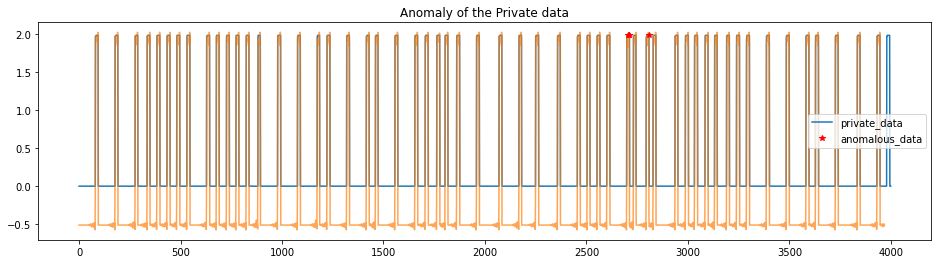

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
'''
anomalous_data_indices = []
predict_data = [0]*4000
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
  if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):   # Sliding
  # if np.all(temp[data_idx - TIME_STEPS + 1 : data_idx]):   # Sliding
    anomalous_data_indices.append(data_idx)
anomalous_data_indices = tempg
for j in anomalous_data_indices:
  predict_data[j] = 1
'''
df_subset_priv = private_data.iloc[tempg_private]
fig, ax = plt.subplots(figsize=(16, 4))
plt.title("Anomaly of the Private data")
private_data.plot(legend=True, ax=ax)
plt.plot(x_private_pred[:, 0, 0], alpha=0.7, )
df_subset_priv.columns = ['anomalous_data']
df_subset_priv[df_subset_priv.columns[0]].plot(legend=True, ax=ax, style='r*')
plt.show()

Overlay the anomalies on the original test data plot

In [ ]:
# TN, FP, FN, TP = confusion_matrix(np.array(test_data['label']), predict_data).ravel()
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)
# accuracy = (TP + TN) / (TP + FN + FP + TN)
# f1_score = 2*TP / (2*TP + FP + FN)

metric_combined = 0.5*precision + 0.25*recall + 0.25*f1_score #+ 0.1*accuracy
print('* metric_combined:'.ljust(20), metric_combined)
print('* roc_auc_score:'.ljust(20),   roc_auc)
print('* precision:'.ljust(20),       precision)
print('* recall:'.ljust(20),          recall)
print('* accuracy:'.ljust(20),        accuracy)
print('* f1_score:'.ljust(20),        f1_score)
print('-'*40, '\n', OmegaConf.to_yaml(conf))

# wandb.log({"metric_combined": metric_combined})
# wandb.log({"roc_auc_score": roc_auc})
# wandb.log({"precision" : precision})
# wandb.log({"recall" : recall})
# wandb.log({"accuracy" : accuracy})
# wandb.log({"f1_score" : f1_score})
# wandb.log({"anomaly_detection": wandb.Image(fig)})
# wandb.log({"ROC_AUC": wandb.Image(fig_auc)})

* metric_combined:   0.8385425664422641
* roc_auc_score:     0.9333232672068617
* precision:         0.8461538461538461
* recall:            0.825938566552901
* accuracy:          0.97625
* f1_score:          0.8359240069084629
---------------------------------------- 
 lr: 0.005
epoch: 100
batch_size: 64
loss_func: mse
dropout: 0.2
architecture: AE
dataset: sensor_C
TIME_STEPS: 32
kernel_size: 8
param_m: 2
stride: 2
scaler: Robust



In [ ]:
l = ['A', 'B', 'C', 'D', 'E']
for i in range(len(l)):
  if config['dataset'] == f'sensor_{l[i]}':
    id = [4000*i, 4000+4000*i]
mae_loss = pd.DataFrame(test_mae_loss, columns=['pred'], dtype='float', index=[i for i in range(id[0], id[1])])
mae_loss.index.name='id'
mae_loss.to_csv(f"pub_{config['dataset']}.csv", float_format=True)#, index=False)
priv_mae_loss = pd.DataFrame(private_mae_loss, columns=['pred'], dtype='float', index=[i+20000 for i in range(id[0], id[1])])
priv_mae_loss.index.name='id'
priv_mae_loss.to_csv(f"priv_{config['dataset']}.csv", float_format=True)#, index=False)

# score_table_artifact = wandb.Artifact("score_artifact", type="dataset")
# score_table_artifact.add_file(f"pub_{config['dataset']}.csv")
# score_table_artifact.add_file(f"priv_{config['dataset']}.csv")
# wandb.log_artifact(score_table_artifact)

In [ ]:
temp_df = pd.DataFrame()
for i in range(len(l)):
  print(f"pub_{config['dataset'][:-1]}{l[i]}.csv")
  h = pd.read_csv(f"pub_{config['dataset'][:-1]}{l[i]}.csv", index_col=False, parse_dates=False, usecols=['id', 'pred'])
  temp_df = temp_df.append(h, ignore_index=True)
for i in range(len(l)):
  print(f"priv_{config['dataset'][:-1]}{l[i]}.csv")
  h = pd.read_csv(f"priv_{config['dataset'][:-1]}{l[i]}.csv", index_col=False, parse_dates=False, usecols=['id', 'pred'])
  temp_df = temp_df.append(h, ignore_index=True)
temp_df.to_csv("submission.csv", float_format=True, index=False)

pub_sensor_A.csv
pub_sensor_B.csv
pub_sensor_C.csv
pub_sensor_D.csv
pub_sensor_E.csv
priv_sensor_A.csv
priv_sensor_B.csv
priv_sensor_C.csv
priv_sensor_D.csv
priv_sensor_E.csv


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' /root/.kaggle

In [ ]:
# !kaggle competitions submit -c ccbda2022spring-hw3 -f submission.csv -m ""

100% 1.04M/1.04M [00:00<00:00, 3.34MB/s]
Successfully submitted to CCBDA 2022 Spring-HW3

In [ ]:
# wandb.finish()

In [ ]:
# dummy = [0]*40000
# dummy_loss = pd.DataFrame(dummy, columns=['pred'], dtype='float', index=[i for i in range(40000)])
# dummy_loss.index.name='id'
# dummy_loss.to_csv("dummy_submission.csv", float_format=True)
# !kaggle competitions submit -c ccbda2022spring-hw3 -f dummy_submission.csv -m "this is a dummy submission"